# Idoven Interview Challenge

This notebook is the submission of Killian Smith as part of the interview process for _ML Engineer_ at Idoven.

## Instructions

The project description for this challenge is available from [github](https://github.com/idoven/Idoven-Data-Scientist). Important exerps from the repository *README*:

> We've tried to keep this task as similar to working here as possible. With that in mind, we think you'll know better than us what can be achieved with this. So there's no specific "thing" we want you to find or do. We want you to explore it as you would if you were working here.
>
> We'd like you to analyse it and give us some insights. The insights should be useful and actionable in some way.
>
> We ask data scientist do want to join Idoven to work with anonymised patient data, and on the basis of this data be able to:
>
>    - Be able to read the ECG files and corresponding annotations
>    - Show how they will work on the signal and plot the signal in appropriate manner to be read by a doctor
>    - Identify the heart beat of the signal, average and total heart beat in the signal
>    - Identify the complex QRS in the signal and been able to annotate on it
>
> As a result we expect a github project with and extructure that will include:
>
>    - Reference documentation used
>    - Jupyter Notebook, in an running environment, Colab, Docker.
>    - An explanation of the work done and lessons learned.


> We like to have a real work example work flow, we wencorage you to do a pull request and send the pull request for evaluation.


> We want to see what it's like to work with you, and the quality of work you'd produce. This is a chance for both sides to see how that is.


The primary task is to show an example workflow for an exploratory analysis of ECG data. The dataset used is the [PTB-XL](https://physionet.org/content/ptb-xl/1.0.2/) made available by the [PhysioNet](https://physionet.org/) group. Note that the current version of the data (as of 2022-12-10) is v1.0.3; however in this analysis we are using v1.0.2 to remain consistent with the provided data retrieval script (i.e.- using the same dataset as other canidates).

The docker container provides a volume that contains the full dataset, located at `/home/guest/project/data/`. If this is not found, please be sure to run `make get-data` and `make docker-volume` from the project directory. This will download the compressed *PTB-XL* dataset, extract the files, and build the docker volume. Note that it could take a while to download the dataset, depending on your internet connection.

## Project Outline

Before we get started, lets make a list of what we would like to accomplish:

  - [x] Read in datasets and explore contents
  - [x] Clean and format datasets into something nicer to work with
  - [x] Plot dataset metadata to get a better feel for the system
  - [x] Task 1: Plot ECG 
  - [ ] Task 2: Statistics (total beats, average rate, etc)
  - [X] Task 3: FFT
  - [ ] Task 4: Feature extraction (P,QRS,T)
  - [X] Task 5: Time-Frequency plots
  - [ ] Task 6: Classification (CNN)

Before we start, lets set up out imports. The first batch of imports are to add quality of life functions to python.

In [1]:
import os
import ast
import functools

Next, lets import numeric and scientific programming libraries.

In [2]:
import numpy as np
import scipy

Since we are going to be working with ECG datasets, we probably will want to import libraries for working with signal processing. 

In [3]:
import wfdb
import pywt

This challenge also involves processing lots of tabular data and making plots, so lets import a dataframe library and plotting utilities.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

Lastly, this challenge is for a ML engineer position, so we should probably be using some ML libraries.

In [5]:
import sklearn as skl
import tensorflow as tf
import keras

2022-12-13 22:21:45.904141: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-13 22:21:46.463671: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-13 22:21:46.463704: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-13 22:21:48.550096: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

## Read Dataset

Before we dive in, make sure that the dataset has been succecfully downloaded and unzipped. You should see a non-empty directory `./project/data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/`. If this is not the case, please run `make build-data-volume` from the project root directory.

In the rest of the script, we will refer to this location as `datadir`.

In [6]:
datadir = '/home/guest/project/data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/'

The **PTB-XL** dataset provides a sample python script for reading in the database. We will use this as a starting point, with minor changes.

The first thing we do is read in the database file.

In [7]:
db = pd.read_csv(os.path.join(datadir,'ptbxl_database.csv'),index_col='ecg_id',sep=',') 
db.scp_codes = db.scp_codes.apply(lambda x: ast.literal_eval(x))

print("Shape: {0}\n\nColumns:\n{1}/n".format(db.shape, list(db.columns)))

Shape: (21801, 43)

Columns:
['patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site', 'device', 'recording_date', 'report', 'scp_codes', 'heart_axis', 'infarction_stadium1', 'infarction_stadium2', 'validated_by', 'second_opinion', 'initial_autogenerated_report', 'validated_by_human', 'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems', 'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr', 'r_peaks', 'RS-LVH', 'S12-LVH', 'R56-LVH', 'QRS-LVH', 'LI-LVH', 'SLI-LVH', 'QRS-CLBB', 'ST-ELEV-MI', 'ST-DEPR-MI', 'Q-ISC', 'Q-ISC-QPeak', 'Q-ISC-V2V3', 'Q-ISC-RPeak', 'STRAIN', 'MI-ALL']/n


The **PTB-XL** script also contains a useful function for reading in a ECG dataframe that matches the database. We will refrain from creating the ECG dataframe for now, as we will likely be doing some filtering of the database first.

In [8]:
def load_raw_data(df, sampling_rate):
    '''Create a new dataframe of ecg readings for DF using SAMPLING_RATE.'''
    if sampling_rate == 100:
        data = [ wfdb.rdsamp(os.path.join(datadir,f)) for f in df.filename_lr ]
    else:
        data = [ wfdb.rdsamp(os.path.join(datadir,f)) for f in df.filename_hr ]
    return np.array([ signal for signal, meta in data ])

Before we continue, lets add a column to the database for the *diagnostic_superclass*. To do this we use information  provided by the ECG-SCP annotations file. This column will be the label for the data we feed our ML models.

In [9]:
agg_df = pd.read_csv(os.path.join(datadir,'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    '''Get diagnostic class from ecg-scp code dict. May return more than one class.'''
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

db['diagnostic_superclass'] = db.scp_codes.apply(aggregate_diagnostic)

## Data Exploration and Filtering

### Dataset Labels (Diagnostic)

To start with, lets look at the most interesting field of our data: the labels!

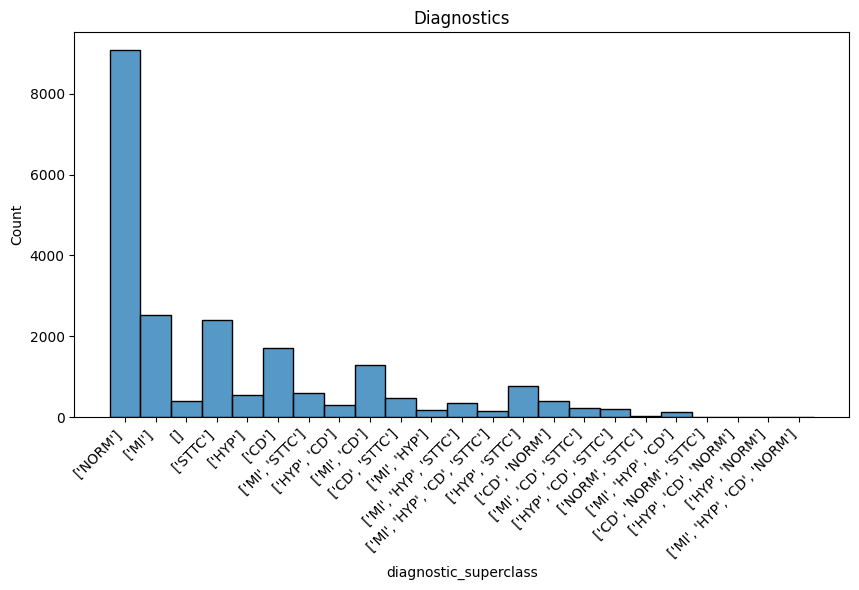

In [10]:
plt.figure(figsize=(10,5))
sbn.histplot(db['diagnostic_superclass'].astype('str'),discrete=True)
plt.xticks(rotation=45, ha='right')
plt.title('Diagnostics')
plt.show()

Looks like most entries are from *"normal"* patients, and quite a few different combinations of diagnostics. We should probably filter the results that do not have any labels.

From this plot, we should keep in mind that a single patient entry could match with multiple tags. This is important to know when building models. Lets add another column to the dataset for the labels in a *one-hot-encoding* format that we can use as the data label in our models. 

In [11]:
def getDiagnosticsTable(df,col):
    '''Build a hashmap of column COL in dataframe DF that we can use for a one-hot-encoding mapping.'''
    unique, table, idx = set(), {}, 0
    for vals in df[col]:
        for val in vals:
            unique.add(val)
    for val in unique:
        table[val] = idx
        idx = idx + 1
    return table

def oneHotEncoding(encoder,labels):
    '''Encode LABELS list as a one-hot-encoding using ENCODER as indices.'''
    result = np.zeros(len(encoder.keys()), dtype=int)
    for label in labels:
        result[encoder[label]] = 1
    return result

def dfOneHotEncode(df,col,name):
    '''Add column to dataframe DF named NAME that is a one-hot-encoding of column COL.'''
    encoder = getDiagnosticsTable(df,col)
    db[name] = db.apply(lambda x: oneHotEncoding(encoder, x[col]), axis=1)
    
    
encoder = getDiagnosticsTable(db,'diagnostic_superclass')    
dfOneHotEncode(db,'diagnostic_superclass','label')

db['label']

ecg_id
1        [0, 0, 1, 0, 0]
2        [0, 0, 1, 0, 0]
3        [0, 0, 1, 0, 0]
4        [0, 0, 1, 0, 0]
5        [0, 0, 1, 0, 0]
              ...       
21833    [0, 0, 0, 1, 0]
21834    [0, 0, 1, 0, 0]
21835    [0, 0, 0, 1, 0]
21836    [0, 0, 1, 0, 0]
21837    [0, 0, 1, 0, 0]
Name: label, Length: 21801, dtype: object

It may also be a good idea to include a *one-hot-encoding* that distinguishes between *normal* and *abnormal*.

In [12]:
# TODO!

Looks good! Now we have a much nicer format to work with inside any models we create. We note here that the output shape of our model should be `(5)`.

This is all quick and dirty, and can be improved (check keys, check bounds, etc.). But for now lets just move on with the exploration. 

### Metadata

We also should look through the available metadata to get a feel for the dataset demographics, be aware of any biases that could be in the dataset, and to look for anything that would need filtered.

Lets start with the patient age field.

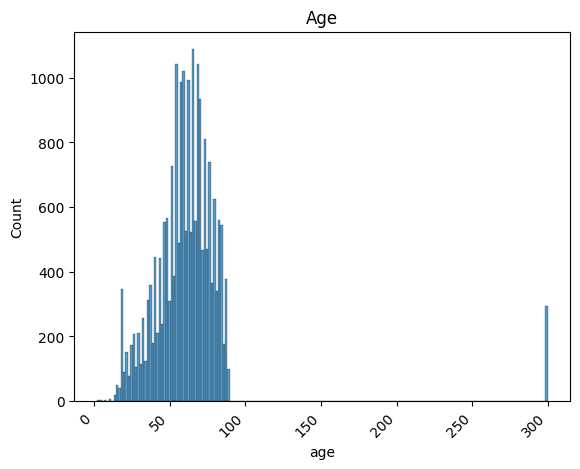

Mean:   62.769781202697125
Median: 62.0
Std:    32.307420634690175



In [13]:
sbn.histplot(db['age'])
plt.xticks(rotation=45, ha='right')
plt.title('Age')
plt.show()

print("Mean:   {0}\nMedian: {1}\nStd:    {2}\n".format(db['age'].mean(), db['age'].median(), db['age'].std()))

Wow, there are a lot of 300 year olds in the dataset. Looks like someone sampled an elf village...

Actually these are just anonymized entries. From the **PTB-XL** webpage:

> The date of birth only as age at the time of the ECG recording, where ages of more than 89 years appear in the range of 300 years in compliance with HIPAA standards.

No need to filter anything here.

The next field that we look at is the patient weight.

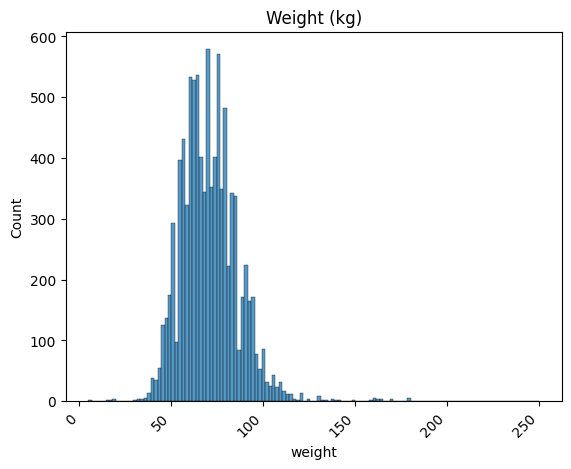

Mean:   70.99639142432605
Median: 70.0
Std:    15.878365132507367



In [14]:
sbn.histplot(db['weight'])
plt.xticks(rotation=45, ha='right')
plt.title('Weight (kg)')
plt.show()

print("Mean:   {0}\nMedian: {1}\nStd:    {2}\n".format(db['weight'].mean(), db['weight'].median(), db['weight'].std()))

Everything looks fine here. Roughly a gaussian distribution, maybe a bit of a tail for the larger weights.

Next up is patient height.

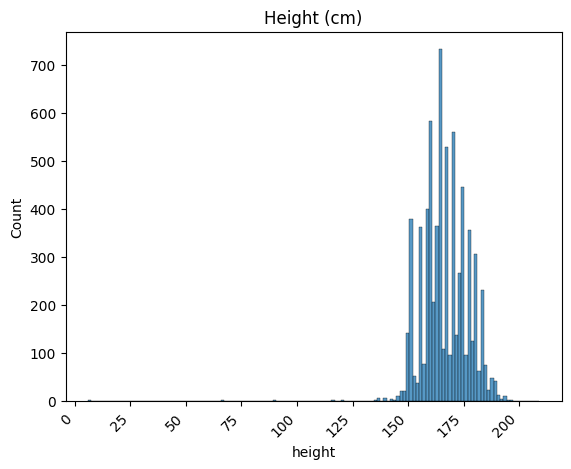

Mean:   166.70322580645163
Median: 166.0
Std:    10.86680364608459



In [15]:
sbn.histplot(db['height'])
plt.xticks(rotation=45, ha='right')
plt.title('Height (cm)')
plt.show()

print("Mean:   {0}\nMedian: {1}\nStd:    {2}\n".format(db['height'].mean(), db['height'].median(), db['height'].std()))

The height data looks like it is probably fine too, roughly gaussian but with a long tail for shorter patients. Probably no need to filter, but be aware that there could be a possibility that our trained models may not work as well for short people.

Next up is the gender distribution of our dataset. From the **PTB-XL** webpage, we learn that 0 is male and 1 is female. Does not look like too much of a bias, so we are probably fine.

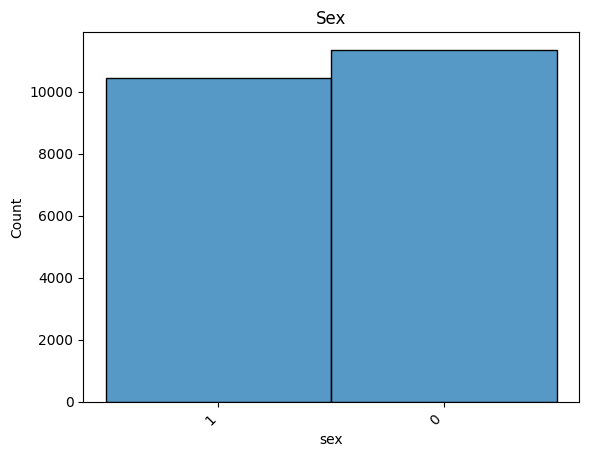

In [16]:
sbn.histplot(db['sex'].astype('str'),discrete=True)
plt.xticks(rotation=45, ha='right')
plt.title('Sex')
plt.show()

The next field is a very important one: the *is validated* field. Since we want to train ML models, we would like to ensure that we are using the best data possible. We should filter out anything that has not been validated.

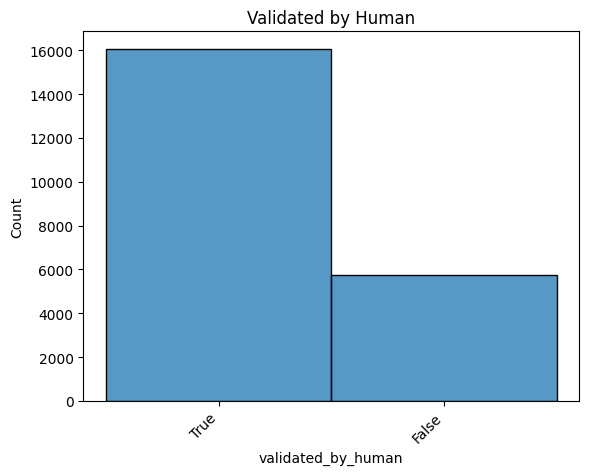

In [17]:
sbn.histplot(db['validated_by_human'].astype('str'),discrete=True)
plt.xticks(rotation=45, ha='right')
plt.title('Validated by Human')
plt.show()

We do not need to have a ML model to see if someone has a pacemaker. There are much easier methods to determine this with high accuracy, like reading a patients charts, xray, asking them, etc ;) Lets filter out the rows that have a pacemaker.

An interesting follow-up problem could be to identify diagnoses of patients with pacemakers, but this would likely have to trained seperately. For now, lets just omit them from our dataset.

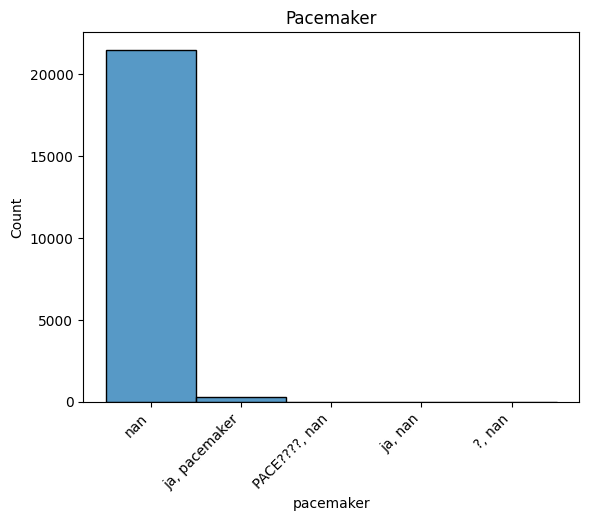

In [18]:
sbn.histplot(db['pacemaker'].astype('str'),discrete=True)
plt.xticks(rotation=45, ha='right')
plt.title('Pacemaker')
plt.show()

The database provides a field for electrode problems. It looks like most of the rows are without problems, so let's just filter out anything that has been reported as having an issue.

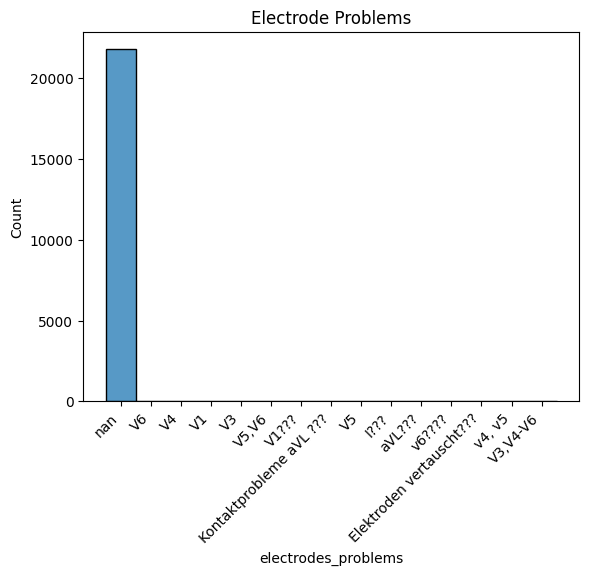

In [19]:
sbn.histplot(db['electrodes_problems'].astype(str),discrete=True)
plt.xticks(rotation=45, ha='right')
plt.title('Electrode Problems')
plt.show()

There is also a field for static noise. Lets take a look to see if this is something that we should filter on.

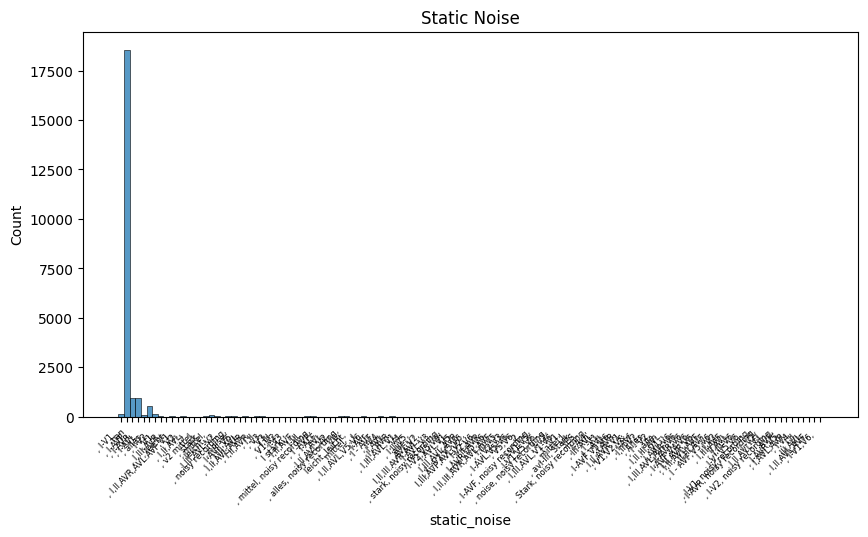

In [20]:
plt.figure(figsize=(10,5))
sbn.histplot(db['static_noise'].astype('str'),discrete=True)
plt.xticks(rotation=45, ha='right', size=6)
plt.title('Static Noise')
plt.show()

Those are a lot of unique fields! Looks like most are empty though. Lets make a frequency table to see the top results.

In [21]:
db['static_noise'].astype('str').value_counts()

nan                           18541
 , I-AVR,                       953
 , I-AVF,                       919
 , alles,                       522
 , I-V1,                        156
                              ...  
 , V5,V6,                         1
 , I-AVL,V5,V6,                   1
 , I,III,V5,                      1
 , I,II,III,AVR,AVL,AVF,          1
 , I-V1,V6,                       1
Name: static_noise, Length: 125, dtype: int64

It looks like most most rows are without any issue. Lets just keep the good rows without static noise.

Also, there are a lot of commas in the names. There might be some errors here when reading into the pandas dataframe. Should look into this later.

There is also a field for burst noise. We will follow a similar procedure to the static noise field, and just keep the good rows.

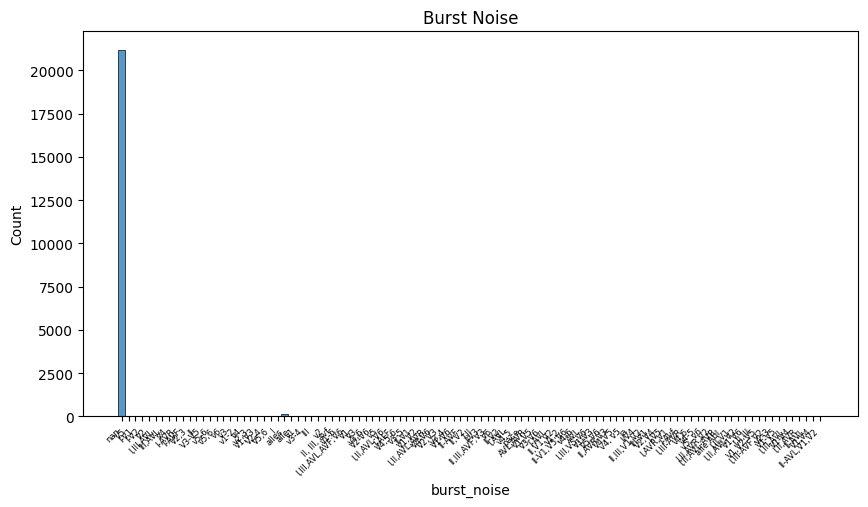

In [22]:
plt.figure(figsize=(10,5))
sbn.histplot(db['burst_noise'].astype('str'),discrete=True)
plt.xticks(rotation=45, ha='right', size=6)
plt.title('Burst Noise')
plt.show()

In [23]:
db['burst_noise'].astype('str').value_counts()

nan             21188
alles             140
I-AVF              47
V1                 46
V1,V2              28
                ...  
v1-2                1
I,III,V5,V6         1
V3-V5               1
I,II,AVL-V6         1
II-AVL,V1,V2        1
Name: burst_noise, Length: 104, dtype: int64

### Build Final Dataset

We are now at a point where we can build the dataset that we will use in our analyses. Lets start with the database dataframe.

In [24]:
Y_full = db[db['validated_by_human'] &           # only validated rows
            db['diagnostic_superclass'] &        # make sure data has label
            db['pacemaker'].isna() &             # filter out pacemakers
            db['electrodes_problems'].isna() &   # filter out problem sets
            db['static_noise'].isna() &          # filter out noisy data
            db['burst_noise'].isna()             # filter out noisy data
           ] 

print("Y-Shape: {0}\n".format(Y_full.shape))

Y-Shape: (13781, 45)



After filtering we still have over 10,000 rows in our table. This is fine for just the database dataframe, but as soon as we try to match ECG reads things could get slow when running on a laptop. To start with, we will try just the first 4000 entries. In the future we can try the same analyses on the full set with a better machine / on a cluster.

In [25]:
Y = Y_full[0:4000]

print("Y-Shape: {0}\n".format(Y.shape))

Y-Shape: (4000, 45)



We need to double check that we have not introduced any biases when down-sampling by so much. It looks like in this case we we lucky and maintained roughly the same distribution. We should be good to continue like this.

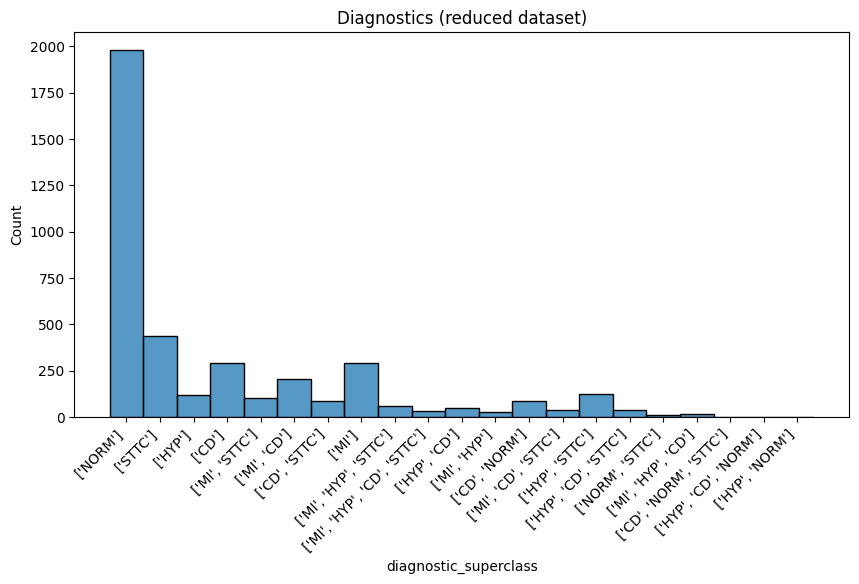

In [26]:
plt.figure(figsize=(10,5))
sbn.histplot(Y['diagnostic_superclass'].astype('str'),discrete=True)
plt.xticks(rotation=45, ha='right')
plt.title('Diagnostics (reduced dataset)')
plt.show()

Next, we load in the corresponding ECG data for each of our rows. To make things faster, we use the down-sampled 100Hz dataset.

This data is stored in a numpy.ndarray with 1000 readings (10 seconds sampled at 100Hz) for each of the 12 leads.



In [27]:
X = load_raw_data(Y, 100)

print("X-Shape: {0}\n".format(X.shape))

X-Shape: (4000, 1000, 12)



TODO - Partition data

In [28]:
# Partition train,validate,test

In [29]:
# Plot labels

## Plotting ECG Data

Now that we have a clean dataset to work with and have properly down-sampled, it is time to dive in! Lets start by plotting the ECG data to get a feel for it.

In [30]:
ecg_leads = ['I','II','III','aV_R','aV_L','aV_F','V_1','V_2','V_3','V_4','V_5','V_6']

Even though we do not know exactly what the leads are, we can still make plots of the 12 leads. Plotting the whole range makes it hard to see features, so lets also pass a `window min` and `window max` parameter when plotting. The following function lets us preview the ECG data for a row in our table.



In [31]:
def plot_ecg(row, wmin, wmax):
    '''Plot the time domain of the 12 lead ECG data.'''
    fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(10, 6), constrained_layout=True)
    fig.suptitle('ECG-' + str(row) + ', 100Hz, ' + str(Y['diagnostic_superclass'][row]))
    xs = np.arange(wmin,wmax)

    for i in range(0,4):
        for j in range(0,3):
            ax[i][j].plot(xs, X[row][:,(i*3+j)][wmin:wmax])
            ax[i][j].set_title(ecg_leads[i*3+j])
            if (i == 3):
                ax[i][j].set_xlabel('sample') 
            if (j == 0):
                ax[i][j].set_ylabel('muV')
    
    plt.show()

Now lets see what the plots look like!

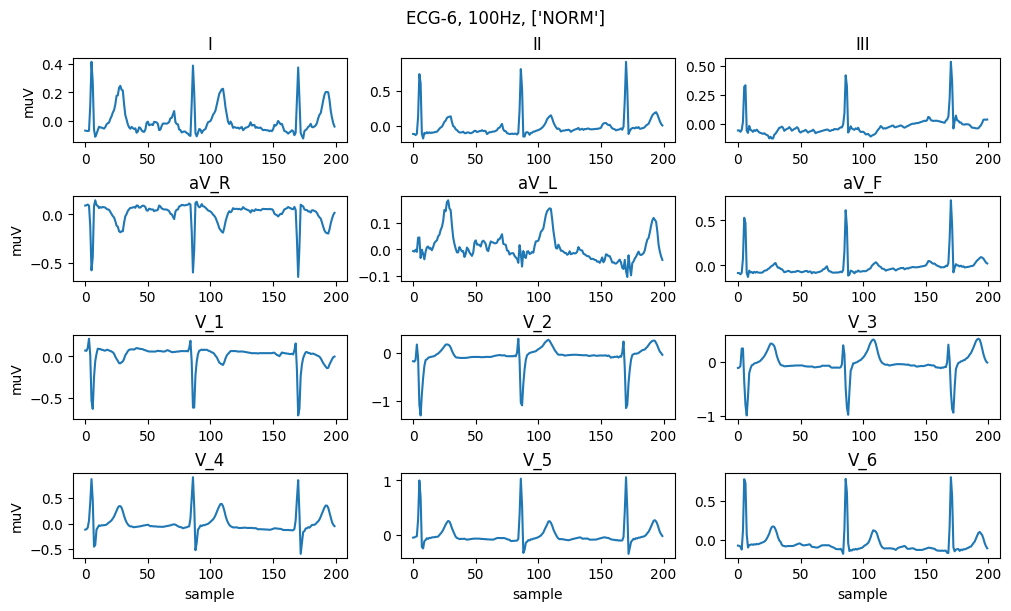

In [32]:
plot_ecg(6,0,200)

Pretty cool looking! Now lets look to see if we can see the difference from a healthy ECG and one that contains a pathology. Lets look in the table to see what we have.

In [33]:
Y['diagnostic_superclass'][0:35]

ecg_id
2         [NORM]
3         [NORM]
4         [NORM]
5         [NORM]
6         [NORM]
7         [NORM]
10        [NORM]
12        [NORM]
14        [NORM]
16        [NORM]
19        [NORM]
21        [NORM]
22        [STTC]
24        [NORM]
27        [NORM]
28        [STTC]
29        [NORM]
30         [HYP]
31        [NORM]
32          [CD]
33        [NORM]
35        [NORM]
37        [NORM]
39    [MI, STTC]
40        [NORM]
41          [CD]
42        [NORM]
43        [NORM]
44        [NORM]
46        [NORM]
50      [MI, CD]
52          [CD]
53        [NORM]
54        [STTC]
55        [NORM]
Name: diagnostic_superclass, dtype: object

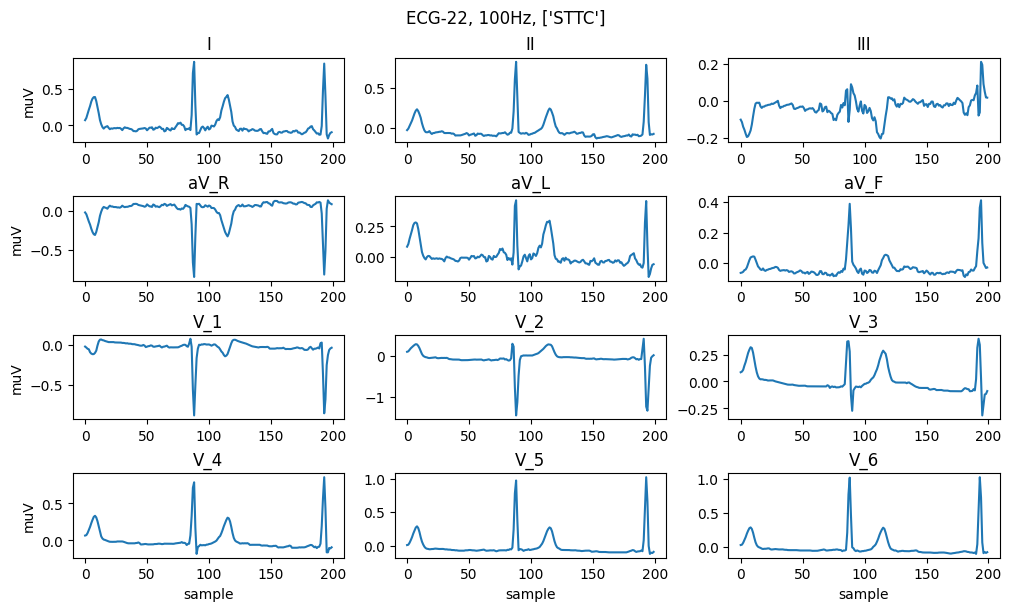

In [34]:
plot_ecg(22,0,200)

The previous plot should show the **STTC** pathology. It is hard for me to tell a difference between this and the normal plot. Maybe there are missing some *P* peaks in the plot? I guess that is the point; we need to be making a classifier that can help non-experts identify cardiac pathologies.

Lets try another one.

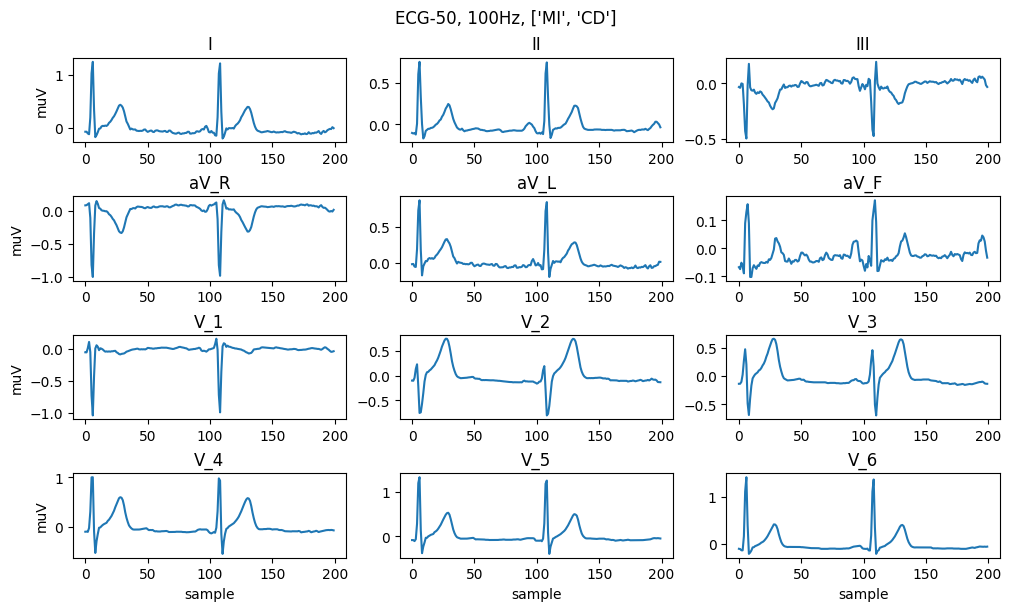

In [35]:
plot_ecg(50,0,200)

Ah, now this one is easier to see. It should be showing **CD** and **MI** pathologies, and we can see some differences. The most prominant difference is the "double-R" in the last row (I really do not know what to call it).

## Plotting Fourier Transform

This is really cool and shows what happens in the time domain, but does not give us a picture of what happens in the frequency domain. Lets plot the Fourier transform of the previous plots to see if that helps us.

In [48]:
def plot_fft(row,sample_rate):
    '''Plot the frequency domain of the 12 lead ECG data.'''
    fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(10, 6), constrained_layout=True)
    fig.suptitle('ECG-' + str(row) + ' FFT, 100Hz, ' + str(Y['diagnostic_superclass'][row]))
    
    for i in range(0,4):
        for j in range(0,3):
            ys = X[row][:,(i*3+j)]
            yf = scipy.fft.fft(ys)
            xf = scipy.fft.fftfreq(len(ys), 1 / sample_rate)
            
            ax[i][j].plot(xf,np.abs(yf))
            ax[i][j].set_title(ecg_leads[i*3+j])
            
            if (i == 3):
                ax[i][j].set_xlabel('frequency (Hz)') 
            if (j == 0):
                ax[i][j].set_ylabel('amplitude')
    
    plt.show()

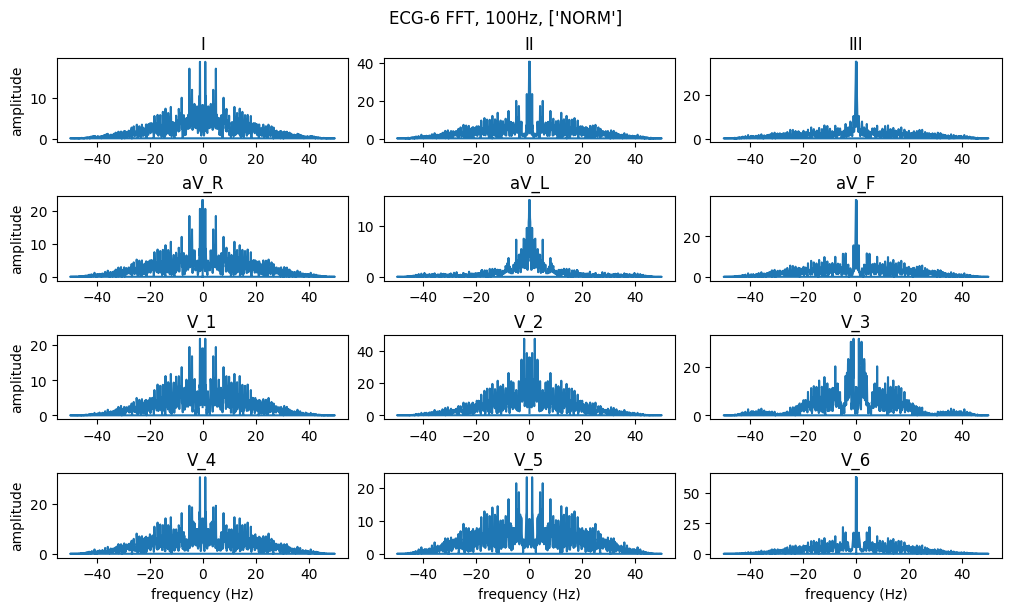

In [37]:
plot_fft(6,100)

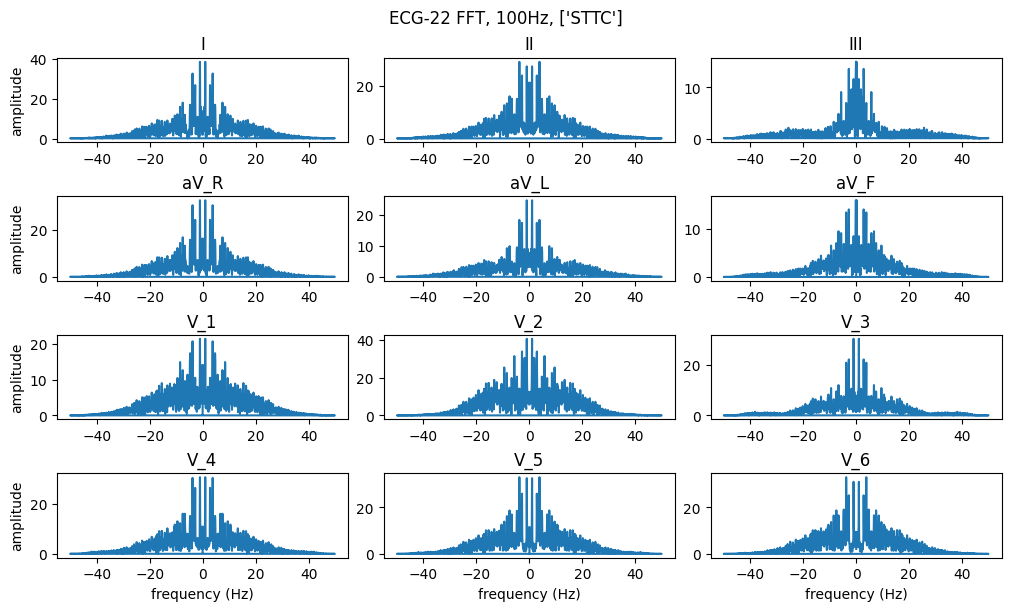

In [38]:
plot_fft(22,100)

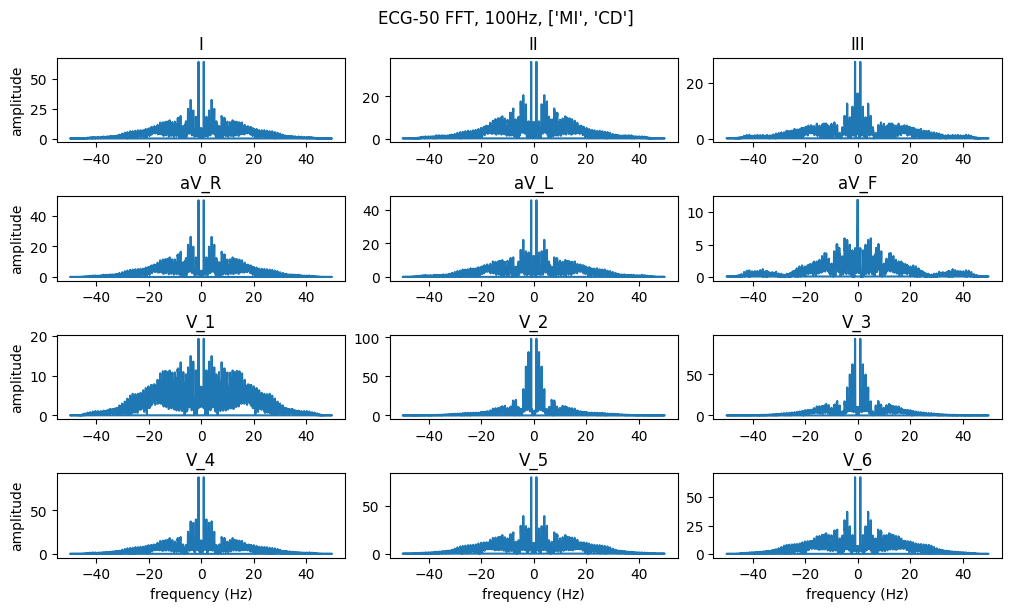

In [39]:
plot_fft(50,100)

Hmmmm, I am not so sure about this transform. It does not look like there are any patterns that really stand out. It still may be good to try and train a CNN to see if there are things that my eyes cannot pick up on. Worth a shot at least. 

Lets move on to the really fun stuff!

## Plotting Scalogram

Before looking into this project, I did not know of the existence of `wavelet transforms` or `scalograms`. Which is a real shame because they are awesome!

The basic idea is to make a compromise between the time and frequency domains, which are mutually excusive. If you know exactly where something is in time, you cannot know its frequency, and vice versa. Like the uncertainty principle applied to signal processing. Using a `wavelet trasform` gives us a fuzzy idea of both.

Python has a nice wavelet library `pywt` that will will be using. Lets check to see what wavelets we can choose. 

In [40]:
 pywt.wavelist(family=None, kind='continuous')

['cgau1',
 'cgau2',
 'cgau3',
 'cgau4',
 'cgau5',
 'cgau6',
 'cgau7',
 'cgau8',
 'cmor',
 'fbsp',
 'gaus1',
 'gaus2',
 'gaus3',
 'gaus4',
 'gaus5',
 'gaus6',
 'gaus7',
 'gaus8',
 'mexh',
 'morl',
 'shan']

It seems like the *Morlet* wavelet is chosen for many introductory examples about wavelets, so lets try applying it. Also, the wavelet *Mexican-Hat* looks like it would be really good at peak detection, so lets try it too.

For this section I am playing very fast and loose. I need to research much more about the effects of wavelet choice are, what features can be detected, and understand what the `scale` parameter actually means / what are reasonable values.

In [41]:
def plotScalogram(row,sample_rate,wavelet):
    '''Plot the time-frequency domain of the 12 lead ECG data.'''
    fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(10, 8), constrained_layout=True)
    fig.suptitle('ECG-' + str(row) + ' Scalogram-' + wavelet + ', 100Hz, ' + str(Y['diagnostic_superclass'][row]))
    
    for i in range(0,4):
        for j in range(0,3):
            ys = X[row][:,(i*3+j)]
            yf = scipy.fft.fft(ys)
            xf = scipy.fft.fftfreq(len(ys), 1 / sample_rate)
            
            # Taken from PYWT documentation
            #dt = 0.01     # 100 Hz sampling
            #fs = 1 / dt   # frequency
            #frequencies = np.array([100, 50, 33.33333333, 25]) / fs # normalize
            #scale = pywt.frequency2scale('morl', xf) #  <-- does not work?
            
            #coefs, freqs = pywt.cwt(signal, scales, wavelets)
            #coefs, freqs = pywt.cwt(ys, xf, 'morl')
            #scales = np.array([128,64,32,16,8,4,2,1,0.5,0.25,0.125])
            scales = np.array([128,64,32,16,8,4,2])
            coefs, freqs = pywt.cwt(ys, scales, wavelet)
            
            # Try with plain, abs, and squared (uncomment one)
            ax[i][j].imshow(#coefs,
                            #abs(coefs),
                            pow(coefs,2),
                            extent=[0,200,100,1],  # images are hard to see, so wee zoom in
                            interpolation='bilinear',
                           )
         
            ax[i][j].invert_yaxis()
            ax[i][j].set_title(ecg_leads[i*3+j])
            
            if (i == 3):
                ax[i][j].set_xlabel('sample') 
            if (j == 0):
                ax[i][j].set_ylabel('scale')
    
    plt.show()

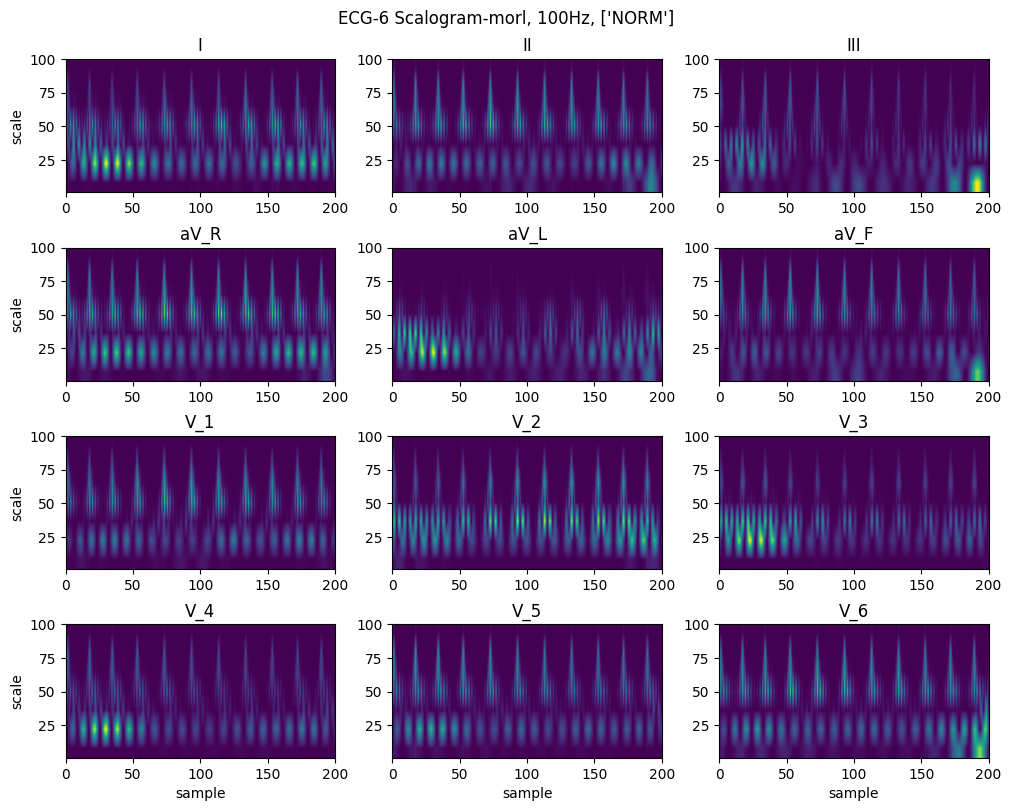

In [42]:
plotScalogram(6,100,'morl')

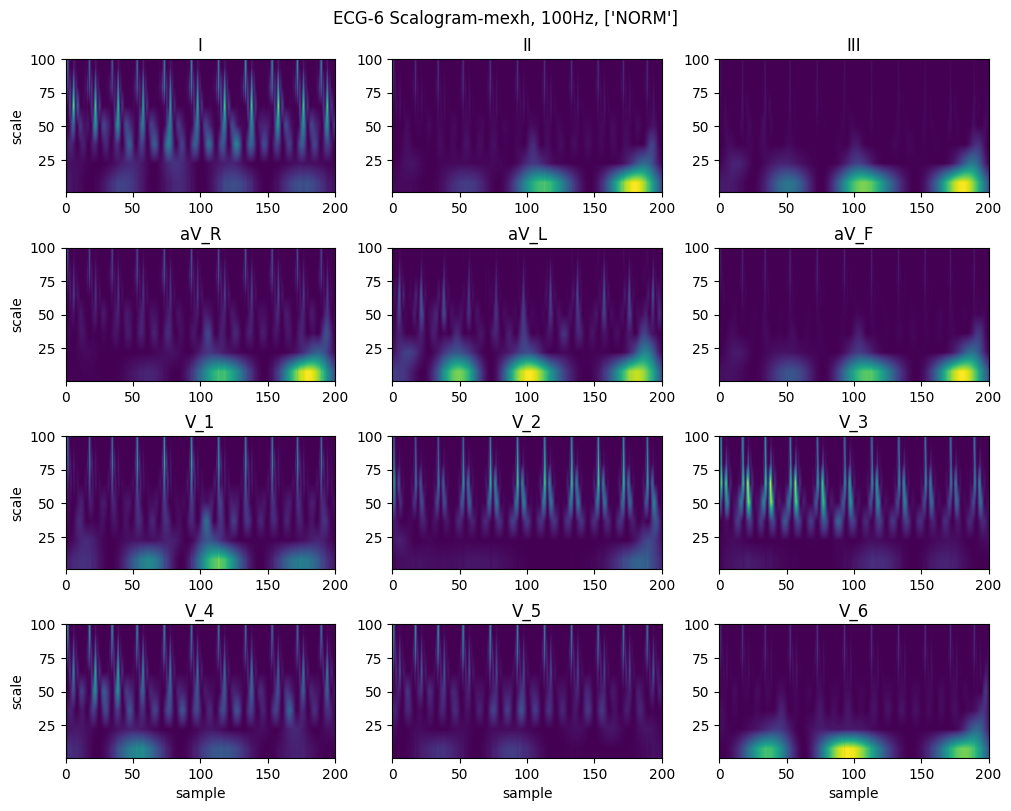

In [43]:
plotScalogram(6,100,'mexh')

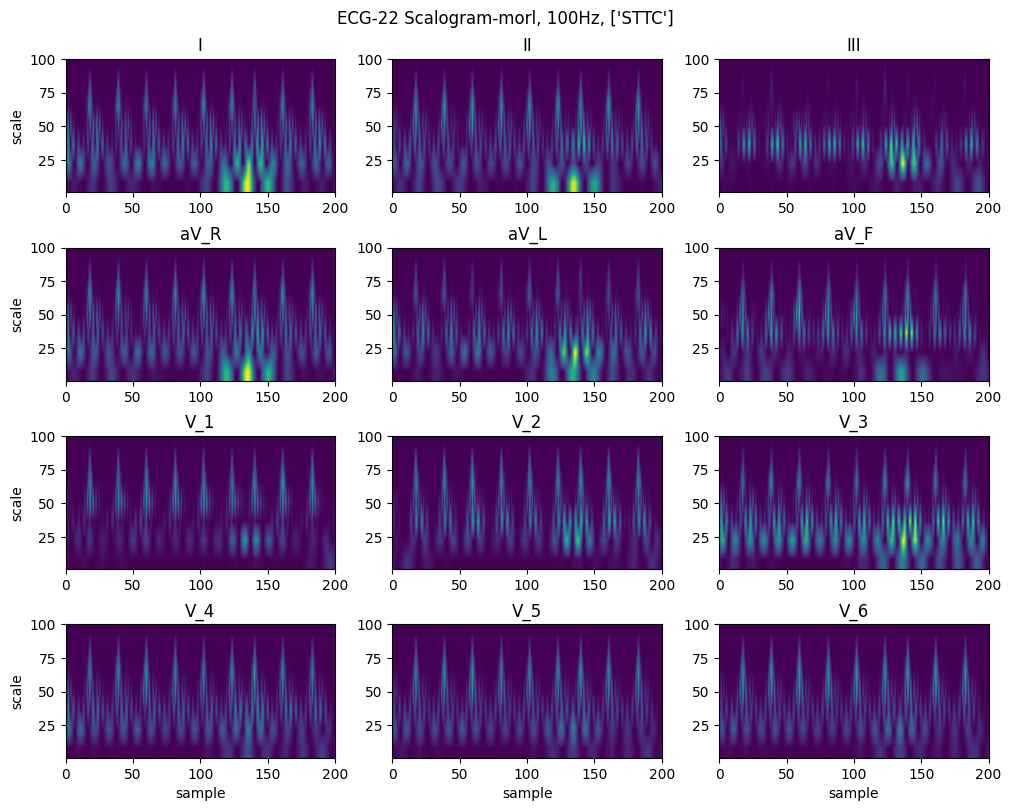

In [44]:
plotScalogram(22,100,'morl')

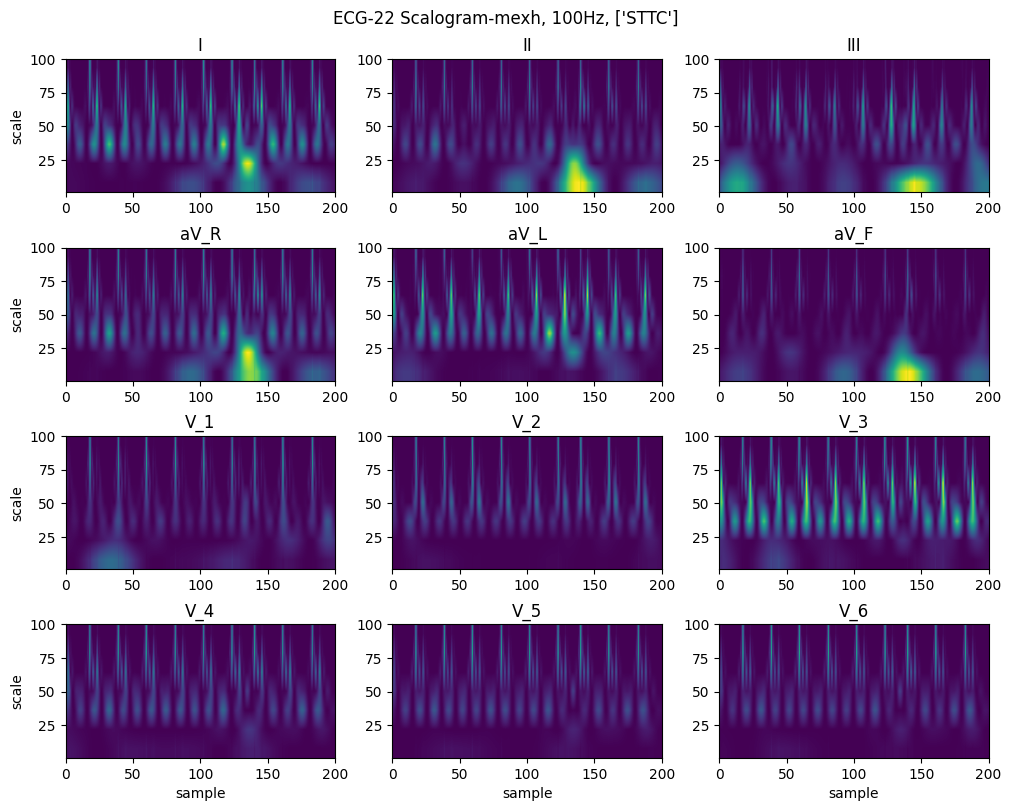

In [45]:
plotScalogram(22,100,'mexh')

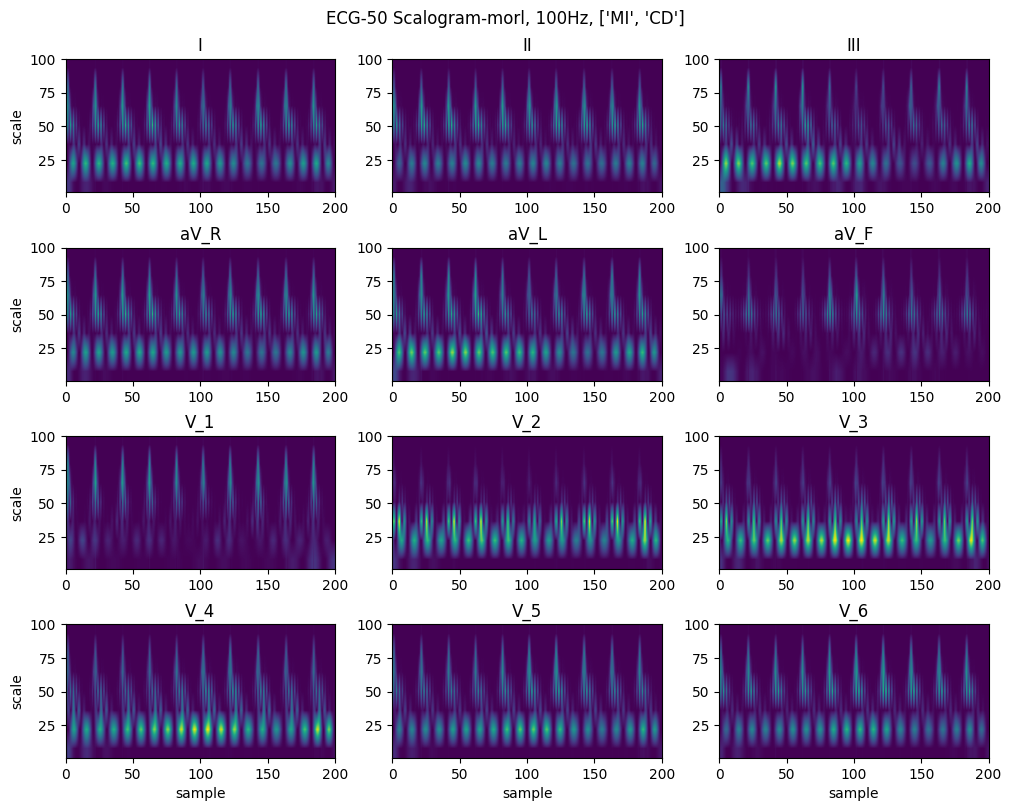

In [46]:
plotScalogram(50,100,'morl')

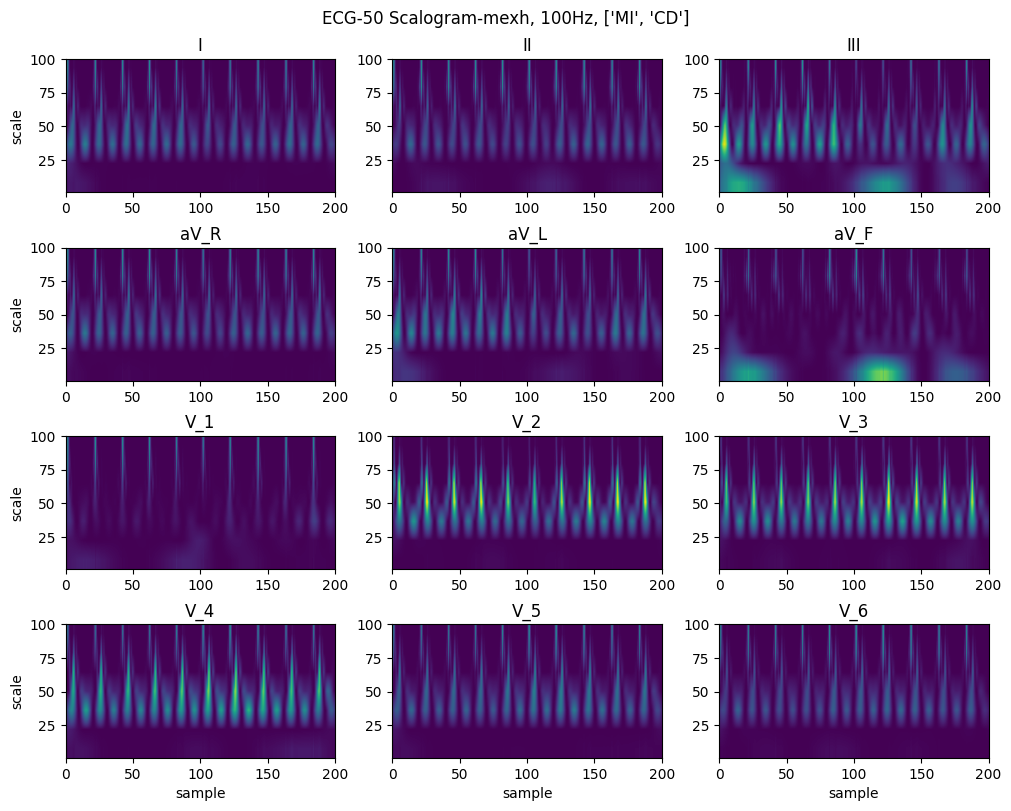

In [47]:
plotScalogram(50,100,'mexh')

Okay, this is soooooo cool! Look at the 'Mexican-hat' wavelet plots: in the normal ECG you can clearly see "blobs" that roughly match where the QRS structures are, and this is not present in either of the ECG with pathologies. This is something that even a non-expert can see. 

The ECG of ['MI','CD'] using 'Morlet' wavelets also shows something interesting: the larger scale peaks are not symetric.

Because there are so many easily distinguished patterns in the scalograms, they look ideal to be feeding into a CNN!

It would be really fun to look at all the different wavelet choices, and see which pathologies are more visible. It would also be extremely beneficial to actually learn about the wavelet transform, what the scale parameter is doing, etc.

There are so many posibilities here!

## Classifiers

At this point we have everything we need to build a classifier. We have our labels in a usable format, and we have at least 3 different data transformations to use as input to our models (ECG, FFT, and Scalograms). 

Since we have 4000 entries in our reduced dataset, lets divide them into 8 partitions of 500 each. Then we can select 6 groups to train, 1 group to validate, and 1 group to test, giving us a ratio of 6:1:1. This is kind of an unusual ratio, but it works nice in our case. If we are randomly selecting these partitions, we have $2 \times {8 \choose 6} = 56$ possible ML datasets that we can use.

Now we have some choices: we can use domain knowlege along with wave morphology and use *"classical"* approaches like clustering, regression, decision trees, etc, or we can try and use something fancy like a CNN that we do not really need to know any domain knowlege. I think for our case the latter is much more fun, and more relavent to the ML interview.

To start simple, lets try to make a CNN only for the mexican-hat wavelet using lead `aV_L` with `keras`